In [1]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.helpers import *
from trips.solvers.gks_all import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.io import *

In [7]:
def check_if_vector(im, nx, ny):
    if im.shape[1] == 1:
        im_vec = im
    else:
        im_vec = im.reshape((nx*ny, 1)) 
    return im_vec

In [7]:
imvec = check_if_vector(x_true, nx, ny)
imvec.shape

(4096, 1)

In [5]:

xx = Deblur.im_image_dat('satellite')
xx.shape


data already in the path.


(256, 256)

In [18]:
x_true = Deblur.gen_true('satellite')
x_true

data already in the path.


AttributeError: 'NoneType' object has no attribute 'shape'

In [8]:
def add_noise(b_true, opt, noise_level, nx, ny):
        b_true = check_if_vector(b_true, nx, ny)
        if (opt == 'Gaussian'):
            e = np.random.randn(nx*ny, 1)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = np.linalg.norm(sig_obs*e)
            b_meas_im = b_meas.reshape((nx, ny))
        return (b_meas_im, delta)

In [9]:
(b_meas_im, delta) = add_noise(b_true, opt = 'Gaussian', noise_level = 0.01, nx= nx, ny = ny)

AttributeError: 'NoneType' object has no attribute 'shape'

In [4]:
Deblur = Deblurring()
x_true = Deblur.gen_true('satellite', nx = 20, ny = 20)

data already in the path.


In [2]:
# Deblurring example test problem
Deblur = Deblurring()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
nx = 64 # Define the first dimension of the image
ny = 64 # Define the second dimension of the image
spread = 0.7 # The PSF parameter
choose_image = 'satellite' #The choice of the image:
# Options for the choice of the image are Himage, satellite64, satellite128, edges
if generate_matrix == True:
        shape = (nx, ny)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, nx, ny)
x_true = Deblur.gen_true(choose_image)
b_true = Deblur.gen_data(x_true, generate_matrix)
(b, delta) = Deblur.add_noise(b_true, opt = 'Gaussian', noise_level = 0.01)

data already in the path.


In [9]:
delta
la.norm(b.reshape((-1,1))-b_true.reshape((-1,1)))

0.11688492186757742

In [ ]:
from trips.solvers.Hybrid_LSQR import *
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = hybrid_lsqr(A, b_vec, n_iter = 10, regparam = 'dp', x_true = x_true, delta = deltavar)

0.11688492186757742

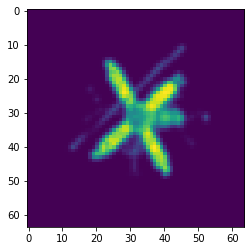

In [14]:
b.shape
plt.imshow(b_true.reshape((nx, ny)))
delta

In [19]:
Deblur2 = Deblurring()
nx = 128
ny = 128
A = Deblur2.forward_Op([11,11], 0.7, nx, ny)
choose_image = 'satellite'
generate_matrix = False
x_true = Deblur2.gen_true(choose_image)
b_true = Deblur2.gen_data(x_true, generate_matrix)
(b, delta) = Deblur2.add_noise(b_true, opt= 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

data already in the path.


0.24837874396026605

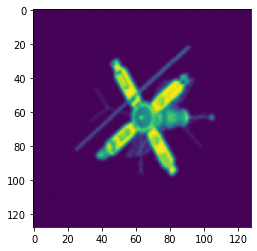

In [20]:
plt.imshow(b)
b.shape
delta

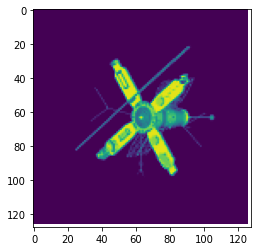

In [9]:
A
aa = x_true[:-1, :-1]
plt.imshow(x_true)

(-0.5, 127.5, 127.5, -0.5)

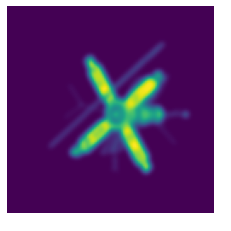

In [37]:
plt.imshow(b_true.reshape((nx, ny)))
plt.axis('off')

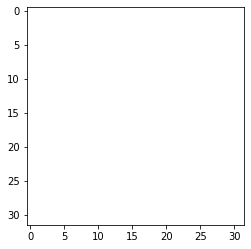

In [4]:

plt.imshow(b_true.reshape((nx,ny)))

In [9]:
from trips.utils import *

In [13]:
x_true.shape

(32, 32)

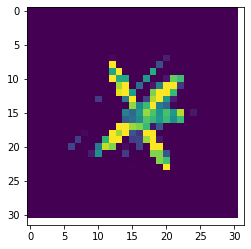

In [15]:
x = check_if_vector(x_true, nx, ny)
plt.imshow(x.reshape((nx, ny)))

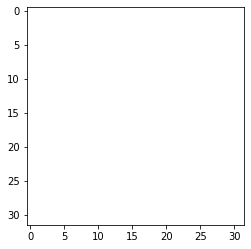

In [23]:
bb = A@x
plt.imshow(bb.reshape((nx, ny)))

In [19]:
A.shape

(1024, 1024)

In [20]:
x_true

array([[ 0.,  0.,  0., ...,  0.,  0., nan],
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       [ 0.,  0.,  0., ...,  0.,  0., nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [16]:
b_true = Deblur.gen_data(x_true, generate_matrix)

In [17]:
def get_image_dat(dataset = 'satellite'):

    assert dataset in ['satellite', 'hubble', 'star']

    if exists(f'./data/image_data/{dataset}.mat'):
        print('data already downloaded.')
    else:
        print("downloading...")

        if not exists('./data'):
            mkdir("./data")

        if not exists('./data/image_data'):
            mkdir("./data/image_data")

        r = requests.get(f'https://drive.google.com/file/d/1nOknOHtxzUrSetf2f0kwcyeYFTe62i11/view?usp=share_link/{dataset}.mat')

        with open(f'./data/image_data/{dataset}.mat', "wb") as file:

            file.write(r.content)

        print("downloaded.")


"""
Generate image data
"""
def generate_image_dat(im):
    get_image_data(im)
    currentpath = os.getcwd()
    f = spio.loadmat(f'./data/image_data/{im}.mat')
    X = f['x_true']
    X_true = X/X.max()
    nx, ny = X_true.shape  
    x_truef = X_true.reshape((-1,1))
    return X_true

def im_image_datt(im):
    assert im in ['satellite', 'hubble', 'star', 'h_im']
    if exists(f'./data/image_data/{im}.mat'):
        print('data already in the path.')
    else:
        print("Please make sure your data are on the data folder!")
    f = spio.loadmat(f'./data/image_data/{im}.mat')
    X = f['x_true']
    return X

In [18]:
hh = im_image_datt('satellite')

data already in the path.


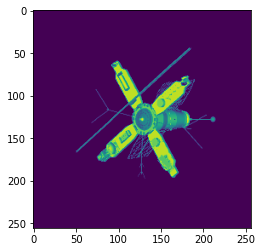

In [22]:
plt.imshow(hh)

In [25]:
def get_input_image_size(image):
    imshape = image.shape
    if imshape[1] == 1:
        nx = int(np.sqrt(imshape[0]))
        ny = int(np.sqrt(imshape[0]))
    else:
        nx = imshape[0]
        ny = imshape[1]
    newshape = (nx, ny)
    return newshape

In [26]:
im = 'h_im'
xx = im_image_dat(im)

data already in the path.


In [27]:
shape = get_input_image_size(xx)
shape

(64, 64)

In [28]:

def image_to_new_size(image, n):
    X, Y = np.meshgrid(np.linspace(1, image.shape[1], n[0]), np.linspace(1, image.shape[0], n[1]))
    im = interp2linear(image, X, Y, extrapval=np.nan)
    return im

In [29]:
satellite_300 = get_true_image('h_im', (300,300))
plt.imshow(satellite_300)
plt.axis('off')
satellite_300.shape

NameError: name 'get_true_image' is not defined

In [37]:
gen_im('hubble', (100,100))

TypeError: 'numpy.ndarray' object is not callable

In [45]:
imm[np.isnan(imm)] = 0
imm.shape

(300, 300)

In [46]:
imm[:, 299]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [42]:
imm.shape
imm[:, 297]

array([0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791672,
       0.00791672, 0.00791672, 0.00791672, 0.00791672, 0.00791

data already in the path.


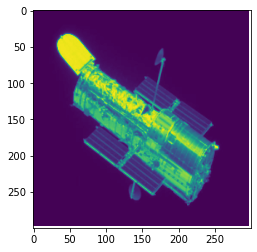

In [38]:
imm = gen_true('hubble', (300, 300))
plt.imshow(imm)

In [30]:
def gen_true(im, required_shape):
    if im in ['satellite', 'hubble', 'h_im']:
        image = im_image_dat(im)
        current_shape = get_input_image_size(xx)
        if ((current_shape[0] is not required_shape[0]) and (current_shape[1] is not required_shape[1])):
            newimage = image_to_new_size(image, required_shape)
    else:
        raise ValueError("The image you requested does not exist! Specify the right name. Options are 'satellite', 'hubble', 'h_im")
    return newimage


In [ ]:
def generate_true(self, choose_image):
        # Specify the path
        path_package = '/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package'
        if choose_image == 'satellite128':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite128.mat')
            # dataa = spio.loadmat('../demos/data/images/satellite128.mat')
            X = dataa['x_true']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'satellite64':
            # dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            X = dataa['x_new']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'edges':
            dataa = spio.loadmat(path_package + '/demos/data/images/edges.mat')
            X = dataa['x']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'pattern1':
            dataa = spio.loadmat(path_package + '/demos/data/images/shape1.mat')
            X = dataa['xtrue']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'Himage':
            dx = 10
            dy = 10
            up_width = 10
            bar_width= 5
            size = 64
            self.nx, self.ny = 64, 64
            h_im = np.zeros((size, size))
            for i in range(size):
                if i < dy or i > size-dy:
                    continue
                for j in range(size):
                    if j < dx or j > size - dx:
                        continue
                    if j < dx + up_width or j > size - dx - up_width:
                        h_im[i, j] = 1
                    if abs(i - size/2) < bar_width:
                        h_im[i, j] = 1
            x_truef = self.vec(h_im)
            # X_true = h_im
        else:
            raise ValueError("The image you requested does not exist! Specify the right name.")
        return (x_truef, self.nx, self.ny)
        ## convert a 2-d image into a 1-d vector

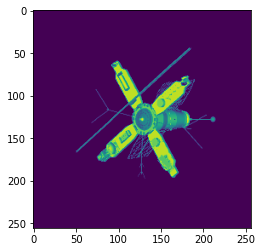

In [26]:
xx.shape
plt.imshow(xx)
xr = xx.reshape((-1,1))
plt.imshow(xr.reshape((256, 256)))

In [12]:
xyy = get_imput_image_size(xx)
xyy

(256, 256)

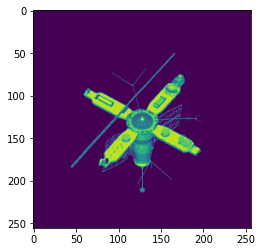

In [20]:
plt.imshow(xx.reshape((xyy[0],xyy[1])))

In [ ]:
dataset = 1
f = spio.loadmat(f'./data/crossphantom_data/DataDynamic_128x{dataset}.mat')

In [3]:
file_path = os.getcwd()
file_path
dataset = 30
im = 'satellite'
f = spio.loadmat(f'./data/image_data/{im}.mat')
f

ValueError: Unknown mat file type, version 34, 103

In [21]:
mat_contents = spio.loadmat(os.path.join(file_path,file_name),\
                        mat_dtype = True,\
                        squeeze_me = True,\
                        struct_as_record = True) 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mirjetapasha/Documents/Research_Projects/TRIPSNOV10/trips-py/demos/image_{dataset}.mat'

In [18]:
xt = mat_contents['x_true']

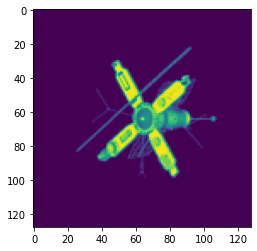

In [19]:
plt.imshow(xt)

In [2]:
import requests
from scipy import sparse
import scipy.io as spio
import numpy as np
import h5py
import astra
from os import mkdir
from os.path import exists
import scipy.sparse as sps
# split into test problems
# separate IO from test problem class implementation
import os,sys
# dataset = 1
# r = requests.get(f'https://drive.google.com/drive/folders/1uexAAYKRnSy0YTXMisk6IxcmwQ66H2by?usp=share_link/image_{dataset}.mat')
# with open(f'./{dataset}.mat', "wb") as file:
#     file.write(r.content)

# with h5py.File(f'./data/image_data/image_{dataset}.mat', 'r') as f:
#     X = f['x_true']

In [3]:
def get_image_data(dataset = 1):

    assert dataset in [1,2,3,4]

    if exists(f'./data/image_data/image_{dataset}.mat'):
        print('data already downloaded.')

    else:
        print("downloading...")

        if not exists('./data'):
            mkdir("./data")

        if not exists('./data/image_data'):
            mkdir("./data/image_data")

        r = requests.get(f'https://drive.google.com/drive/folders/1uexAAYKRnSy0YTXMisk6IxcmwQ66H2by?usp=share_link/image_{dataset}.mat')

        with open(f'./data/image_data/image_{dataset}.mat', "wb") as file:

            file.write(r.content)

        print("downloaded.")

In [7]:
currentpath = os.getcwd()
currentpath

'/Users/mirjetapasha/Documents/Research_Projects/TRIPSNOV10/trips-py/demos'

In [4]:
def generate_image_data2(dataset):
    get_image_data(dataset)
    currentpath = os.getcwd()
    dataa = spio.loadmat(currentpath + '/data/image_data/image_{dataset}.mat')
    # dataa = spio.loadmat('../demos/data/images/satellite128.mat')
    X = dataa['x_true']
    X_true = X/X.max()
    nx, ny = X_true.shape  
    x_truef = X_true.reshape((-1,1))
    return x_truef

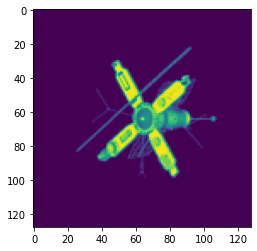

In [36]:
plt.imshow(xx.reshape((128, 128)))

In [50]:
class Deb:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def Gauss(self, PSFdim, PSFspread):
        self.m = PSFdim[0]
        self.n = PSFdim[1]
        self.dim = PSFdim
        self.spread = PSFspread
        self.s1, self.s2 = PSFspread, PSFspread
        # Set up grid points to evaluate the Gaussian function
        x = np.arange(-np.fix(self.n/2), np.ceil(self.n/2))
        y = np.arange(-np.fix(self.m/2), np.ceil(self.m/2))
        X, Y = np.meshgrid(x, y)
        # Compute the Gaussian, and normalize the PSF.
        PSF = np.exp( -0.5* ((X**2)/(self.s1**2) + (Y**2)/(self.s2**2)) )
        PSF /= PSF.sum()
        # find the center
        mm, nn = np.where(PSF == PSF.max())
        center = np.array([mm[0], nn[0]])   
        return PSF, center.astype(int)
    def forward_Op(self, dim, spread, nx, ny):
        PSF, center = self.Gauss(dim, spread)
        proj_forward = lambda X: convolve(X.reshape([nx,ny]), PSF, mode='constant').reshape((-1,1))
        proj_backward = lambda B: convolve(B.reshape([nx,ny]), np.flipud(np.fliplr(PSF)), mode='constant' ).reshape((-1,1))
        blur = pylops.FunctionOperator(proj_forward, proj_backward, nx*ny)
        return blur
    def generate_true(self, choose_image):
        # Specify the path
        path_package = '/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package'
        if choose_image == 'satellite128':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite128.mat')
            # dataa = spio.loadmat('../demos/data/images/satellite128.mat')
            X = dataa['x_true']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'satellite64':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            X = dataa['x_new']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'edges':
            dataa = spio.loadmat(path_package + '/demos/data/images/edges.mat')
            X = dataa['x']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'pattern1':
            dataa = spio.loadmat(path_package + '/demos/data/images/shape1.mat')
            X = dataa['xtrue']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'Himage':
            dx = 10
            dy = 10
            up_width = 10
            bar_width= 5
            size = 64
            self.nx, self.ny = 64, 64
            h_im = np.zeros((size, size))
            for i in range(size):
                if i < dy or i > size-dy:
                    continue
                for j in range(size):
                    if j < dx or j > size - dx:
                        continue
                    if j < dx + up_width or j > size - dx - up_width:
                        h_im[i, j] = 1
                    if abs(i - size/2) < bar_width:
                        h_im[i, j] = 1
            x_truef = self.vec(h_im)
            # X_true = h_im
        else:
            raise ValueError("The image you requested does not exist! Specify the right name.")
        return (x_truef, self.nx, self.ny)
        ## convert a 2-d image into a 1-d vector
    def vec(self, image):
        sh = image.shape
        return image.reshape((sh[0]*sh[1]))
    ## convert a 1-d vector into a 2-d image of the given shape
    def im(self, x, shape):
        return x.reshape(shape)
    ## display a 1-d vector as a 2-d image
    def display_vec(self, vec, shape, scale = 1):
        image = self.im(vec, shape)
        plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
        plt.axis('off')
        plt.show()
        ## a helper function for creating the blurring operator
    def get_column_sum(self, spread):
        length = 40
        raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                        for i in range(length) for j in range(length)])
        return np.sum(raw[raw > 0.0001])
    ## blurs a single pixel at center with a specified Gaussian spread
    def P(self, spread, center, shape):
        image = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
                if v < 0.0001:
                    continue
                image[i,j] = v
        return image

    def forward_Op_matrix(self, spread, shape, nx, ny):
        ## construct our blurring matrix with a Gaussian spread and zero boundary conditions
        #normalize = get_column_sum(spread)
        m = shape[0]
        n = shape[1]
        A = np.zeros((m*n, m*n))
        count = 0
        self.spread = spread
        self.shape = shape
        for i in range(m):
            for j in range(n):
                column = self.vec(self.P(spread, [i, j],  shape))
                A[:, count] = column
                count += 1
        normalize = np.sum(A[:, int(m*n/2 + n/2)])
        A = 1/normalize * A
        return A

    def generate_data(self, x, matrix):
        if matrix == False:
            A = self.forward_Op(self.dim, self.spread, self.nx, self.ny)
            b = A*x
        else:
            A = self.forward_Op_matrix(self.spread, self.shape, self.nx, self.ny)
            b = A@x
        return b
        
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            e = np.random.randn(self.nx*self.ny, 1)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny))
        if (opt == 'Poisson'):
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_im = b_meas.reshape((self.nx, self.ny))
            e = 0
            delta = np.linalg.norm(e)
        if (opt == 'Laplace'):
            e = np.random.laplace(self.nx*self.ny, 1)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny), order='F')
        return (b_meas_im, delta)
    def plot_rec(self, img, save_imgs = False, save_path='./saveImagesDeblurringReconstructions'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            # plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()

    def plot_data(self, img, save_imgs = False, save_path='./saveImagesDeblurringData'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            # plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw() 


In [12]:
x_true.shape

(16384, 1)

In [22]:
Deblur = Deblurring()
nx = 128
ny = 128
# A = Deblur.forward_Op([11,11], 0.5, imagesize_x, imagesize_y)
A = Deblur.forward_Op([11,11], 0.5, nx, ny)
choose_image = 'satellite128'
generate_matrix = False
(x_true, nx, ny) = Deblur.generate_true(choose_image)
b_true = Deblur.generate_data(x_true, generate_matrix)
(b, e) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

I = pylops.Identity(imagesize_x*imagesize_y) # identity operator
D = first_derivative_operator(n=imagesize_x*imagesize_y) # first derivative operator
D2 = D @ D # second derivative operator

In [23]:
A.shape

(16384, 16384)

In [24]:
b.shape

(128, 128)

In [18]:
x_true.shape

(16384, 1)

In [2]:

class Deblurring:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def Gauss(self, PSFdim, PSFspread):
        self.m = PSFdim[0]
        self.n = PSFdim[1]
        self.dim = PSFdim
        self.spread = PSFspread
        self.s1, self.s2 = PSFspread, PSFspread
        # Set up grid points to evaluate the Gaussian function
        x = np.arange(-np.fix(self.n/2), np.ceil(self.n/2))
        y = np.arange(-np.fix(self.m/2), np.ceil(self.m/2))
        X, Y = np.meshgrid(x, y)
        # Compute the Gaussian, and normalize the PSF.
        PSF = np.exp( -0.5* ((X**2)/(self.s1**2) + (Y**2)/(self.s2**2)) )
        PSF /= PSF.sum()
        # find the center
        mm, nn = np.where(PSF == PSF.max())
        center = np.array([mm[0], nn[0]])   
        return PSF, center.astype(int)
    def forward_Op(self, dim, spread, nx, ny):
        PSF, center = self.Gauss(dim, spread)
        proj_forward = lambda X: convolve(X.reshape([nx,ny]), PSF, mode='constant').reshape((-1,1))
        proj_backward = lambda B: convolve(B.reshape([nx,ny]), np.flipud(np.fliplr(PSF)), mode='constant' ).reshape((-1,1))
        blur = pylops.FunctionOperator(proj_forward, proj_backward, nx*ny)
        return blur
    def generate_true(self, choose_image):
        # Specify the path
        path_package = '/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package'
        if choose_image == 'satellite128':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite128.mat')
            X = dataa['x_true']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'satellite64':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            X = dataa['x_new']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'edges':
            dataa = spio.loadmat(path_package + '/demos/data/images/edges.mat')
            X = dataa['x']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'pattern1':
            dataa = spio.loadmat(path_package + '/demos/data/images/shape1.mat')
            X = dataa['xtrue']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.reshape((-1,1))
        elif choose_image == 'Himage':
            dx = 10
            dy = 10
            up_width = 10
            bar_width= 5
            size = 64
            self.nx, self.ny = 64, 64
            h_im = np.zeros((size, size))
            for i in range(size):
                if i < dy or i > size-dy:
                    continue
                for j in range(size):
                    if j < dx or j > size - dx:
                        continue
                    if j < dx + up_width or j > size - dx - up_width:
                        h_im[i, j] = 1
                    if abs(i - size/2) < bar_width:
                        h_im[i, j] = 1
            x_truef = self.vec(h_im)
            # X_true = h_im
        else:
            raise ValueError("The image you requested does not exist! Specify the right name.")
        return (x_truef, self.nx, self.ny)
        ## convert a 2-d image into a 1-d vector
    def vec(self, image):
        sh = image.shape
        return image.reshape((sh[0]*sh[1]))
    ## convert a 1-d vector into a 2-d image of the given shape
    def im(self, x, shape):
        return x.reshape(shape)
    ## display a 1-d vector as a 2-d image
    def display_vec(self, vec, shape, scale = 1):
        image = self.im(vec, shape)
        plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
        plt.axis('off')
        plt.show()
        ## a helper function for creating the blurring operator
    def get_column_sum(self, spread):
        length = 40
        raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                        for i in range(length) for j in range(length)])
        return np.sum(raw[raw > 0.0001])
    ## blurs a single pixel at center with a specified Gaussian spread
    def P(self, spread, center, shape):
        image = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
                if v < 0.0001:
                    continue
                image[i,j] = v
        return image

    def forward_Op_matrix(self, spread, shape, nx, ny):
        ## construct our blurring matrix with a Gaussian spread and zero boundary conditions
        #normalize = get_column_sum(spread)
        m = shape[0]
        n = shape[1]
        A = np.zeros((m*n, m*n))
        count = 0
        self.spread = spread
        self.shape = shape
        for i in range(m):
            for j in range(n):
                column = self.vec(self.P(spread, [i, j],  shape))
                A[:, count] = column
                count += 1
        normalize = np.sum(A[:, int(m*n/2 + n/2)])
        A = 1/normalize * A
        return A

    def generate_data(self, x, matrix):
        if matrix == False:
            A = self.forward_Op(self.dim, self.spread, self.nx, self.ny)
            b = A*x
        else:
            A = self.forward_Op_matrix(self.spread, self.shape, self.nx, self.ny)
            b = A@x
        return b
        
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            e = np.random.randn(self.nx*self.ny, 1)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny))
        if (opt == 'Poisson'):
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_im = b_meas.reshape((self.nx, self.ny))
            e = 0
            delta = np.linalg.norm(e)
        if (opt == 'Laplace'):
            e = np.random.laplace(self.nx*self.ny, 1)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny), order='F')
        return (b_meas_im, delta)
    def plot_rec(self, img, save_imgs = False, save_path='./saveImagesDeblurringReconstructions'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            # plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()

    def plot_data(self, img, save_imgs = False, save_path='./saveImagesDeblurringData'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            # plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw() 



In [15]:
class Tc():
    def __init__(self,**kwargs):
            seed = kwargs.pop('seed',2022)
    def define_proj_id(self, sizex, sizey, views, **kwargs):
            self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
            self.nx = sizex
            self.ny = sizey
            self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
            self.q = views           # number of projection angles
            self.views = views
            self.theta = np.linspace(0, 2*np.pi, self.q, endpoint=False)   # in rad
            self.source_origin = 3*self.nx                     # source origin distance [cm]
            self.detector_origin = self.nx                      # origin detector distance [cm]
            self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
            self.detector_length = self.detector_pixel_size*self.p   # detector length
            self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
            self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
            self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
            return self.proj_id

    def define_A(self, sizex, sizey, views): 
            proj_id = self.define_proj_id(sizex, sizey, views)  
            self.A = astra.OpTomo(self.proj_id)     
            return self.A

    def forward_Op(self, x, sizex, sizey, views):
        A = self.define_A(sizex, sizey, views)
        operatorf = lambda X: (A*X.reshape((sizex, sizey))).reshape(-1,1)
        operatorb = lambda B: A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, sizex*sizey)
        return OP, A

In [16]:
TT = Tc()

In [17]:
nx = 64
ny = 64
views = 60
x = np.ones((nx*ny,1))
TT.forward_Op(x, nx, ny, views)

(<5400x4096 FunctionOperator with dtype=float64>,
 <5400x4096 OpTomo with dtype=<class 'numpy.float32'>>)